#### Figure detection

Source: http://homes.sice.indiana.edu/sbambach/papers/foosball-tracking.pdf

The goal is to localize the players on the playing field. We can break this further down:

1. normalize the image
2. detect the bars (we skip this for now. we probably want to use hough lines for that)
3. for each bar: use vertical strips to scan for color difference


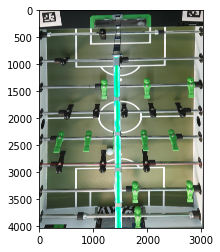

In [2]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import peakutils

%matplotlib inline

# 1. load image
# 2. find homography matrix H using arbitrary points (later we'll use aruco markers to find that point)
# 3. warp image based on H
img = cv2.imread('test.jpg')
plt.imshow(img)

(h, w) = img.shape[:2]
pts_src = np.array([
    [[500, 3500]],
    [[2700, 3500]],
    [[920, 600]],
    [[2400, 600]],
])

pts_dst = np.array(
        [0, 0, w, 0, 0, h, w, h]).reshape(4, 1, -1)

H = cv2.findHomography(pts_src, pts_dst)
img = cv2.warpPerspective(img, H[0], (w, h))

(h, w) = img.shape[:2]
# y pos of bar
ty = 2850
im = img.copy()
cv2.line(im, (0, ty), (w, ty), (255, 0, 0), 3)
plt.imshow(im)

##### Figure Scanning Algorithm (black)

This algorithm basicially follows the paper but is horrificly inefficient. We fix that later

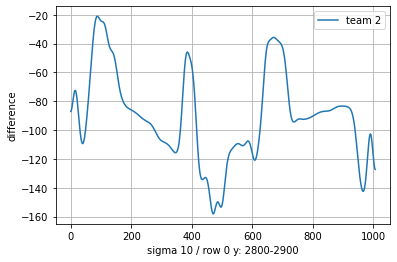

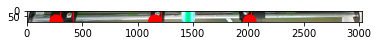

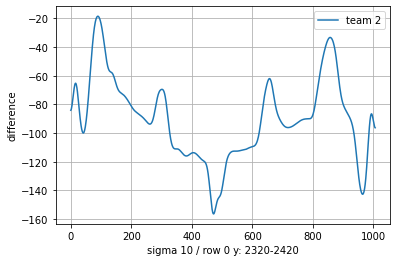

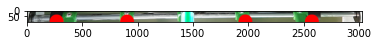

In [64]:
from scipy.ndimage.filters import gaussian_filter
import peakutils

frame = img.copy()
(h, w) = frame.shape[0:2]

def find_figures(y0, y1):
    # we calculate the negative difference of the figure
    # if it is high it should be a figure 
    target_color = (30, 30, 30)
    t2MeanDiffRow = []
    step_size = 3
    x = 0

    while True:
        t2ColDiffArr = []
        if x == w-step_size:
            break

        for y in range(y0, y1):
            # analyze pixels in batch;
            # - get mean color
            # - get diff between target and actual color
            bgrMean = np.mean(frame[y][x:x+step_size], 0)
            diff = np.mean(cv2.absdiff(
                bgrMean, target_color))
            t2ColDiffArr.append(-diff)

        t2ColDiff = np.mean(t2ColDiffArr, 0)
        t2MeanDiffRow.append(t2ColDiff)
        x += step_size

    yMid = y0 + (y1-y0)

    # gauss
    #
    sigma = 10
    t2Blurred = gaussian_filter(t2MeanDiffRow, sigma=sigma)

    indices2 = peakutils.indexes(t2Blurred, thres=0.6, min_dist=w//30)

    fig, ax = plt.subplots()
    ax.plot(t2Blurred, label='team 2')
    plt.legend()
    ax.set(xlabel='sigma {} / row {} y: {}-{}'.format(sigma, row, y0, y1), ylabel='difference')
    ax.grid()
    plt.show()

    for x in indices2:
        x = x*step_size
        cv2.line(frame, (x-step_size, yMid-step_size),
                    (x+step_size, yMid+step_size), (255, 0, 0), int(w/25))
        cv2.line(frame, (x+step_size, yMid-step_size),
                    (x, yMid+step_size), (255, 0, 0), int(w/25))

        
# black 3bar
find_figures(2800, 2900)
plt.imshow(frame[2800:2900])

# green 5bar
find_figures(2320, 2420)
plt.imshow(frame[2320:2420])


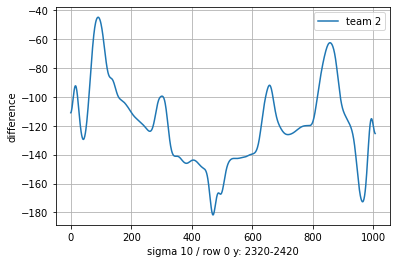

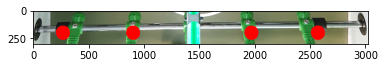

In [37]:
from scipy.ndimage.filters import gaussian_filter
import peakutils

frame = img.copy()

# this is the range of our rod (height = 100px)
rodCandidates = [(2320, 2420)]
(h, w) = frame.shape[0:2]

# we calculate the negative difference of the figure
# if it is high it should be a figure 
target_color = (0, 0, 0)
for row, (y0, y1) in enumerate(rodCandidates):
   t2MeanDiffRow = []
   step_size = 3
   x = 0

   while True:
       t2ColDiffArr = []
       if x == w-step_size:
           break

       for y in range(y0, y1):
           # analyze pixels in batch;
           # - get mean color
           # - get diff between target and actual color
           bgrMean = np.mean(frame[y][x:x+step_size], 0)
           diff = np.mean(cv2.absdiff(
               bgrMean, target_color))
           t2ColDiffArr.append(-diff)

       t2ColDiff = np.mean(t2ColDiffArr, 0)
       t2MeanDiffRow.append(t2ColDiff)
       x += step_size

   yMid = y0 + (y1-y0)

   # gauss
   #
   sigma = 10
   t2Blurred = gaussian_filter(t2MeanDiffRow, sigma=sigma)

   indices2 = peakutils.indexes(t2Blurred, thres=0.5, min_dist=w//30)

   fig, ax = plt.subplots()
   ax.plot(t2Blurred, label='team 2')
   plt.legend()
   ax.set(xlabel='sigma {} / row {} y: {}-{}'.format(sigma, row, y0, y1), ylabel='difference')
   ax.grid()
   plt.show()

   for x in indices2:
       x = x*step_size
       cv2.line(frame, (x-step_size, yMid-step_size),
                   (x+step_size, yMid+step_size), (255, 0, 0), int(w/25))
       cv2.line(frame, (x+step_size, yMid-step_size),
                   (x, yMid+step_size), (255, 0, 0), int(w/25))

plt.imshow(frame[2220:2520])

This is a more efficient implementation using numpy (beware: brainfuck)

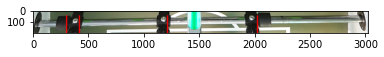

In [60]:
# frame: use cvtColor
#
def find_peaks(frame, target_color, rodCandidate, sigma=5, threshold=0.4, step_size=3):
    (y0, y1) = rodCandidate
    yit = np.arange(y0, y1)
    ySlice = frame[yit]
    (sh, sw) = ySlice.shape[0:2]
    if sw % step_size != 0:
        raise Exception("step_size must be divisor of frame width")

    tc = np.zeros(((sw*sh)//step_size, 3))
    tc[:][:] = target_color

    # get mean for every 3element group
    group_mean = np.mean(
        ySlice.reshape((sw*sh)//step_size, step_size, 3), axis=1)

    # zip mean values and target-color
    mst = np.dstack((group_mean, tc))

    # get abs diff
    ad = np.absolute(np.diff(mst, axis=2))

    # average over color channels
    ad = np.mean(ad, axis=1)

    # average over cols
    rad = np.mean(ad.reshape(sh, sw//step_size), axis=0)

    # repeat values to get full width again
    avgXDiff = np.repeat(rad, step_size, axis=0)
    rowBlurred = gaussian_filter(avgXDiff, sigma=sigma)

    # DEBUG: plot distribution
    #fig, ax = plt.subplots()
    #ax.plot(rowBlurred / max(rowBlurred), label='team 2')
    #plt.legend()
    #ax.set(xlabel='sigma {} / y: {}-{}'.format(sigma, y0, y1), ylabel='difference')
    #ax.grid()
    #plt.show()

    return peakutils.indexes(rowBlurred, thres=threshold, min_dist=sw//30)


####
####
#rodCandidate = (2320, 2420)
rodCandidate = (2800, 2900)
(y0, y1) = rodCandidate
(h, w) = img.shape[0:2]

# HSV colors!
#target_color = (110, 68, 44)
target_color = (255, 255, 255)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
indices = find_peaks(hsv, target_color, rodCandidate, sigma=20, threshold=0.9)

yMid = y0 + (y1-y0)
for x in indices:
    x = int(x)
    cv2.line(img, (x, yMid-100),
                (x, yMid+100), (255, 0, 0), 10)

plt.imshow(img[2750:2950])


In [62]:
def run_find_peaks():
    rodCandidate = (2320, 2420)
    target_color = (110, 68, 44)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    indices = find_peaks(hsv, target_color, rodCandidate)

# perf test
%timeit -r 5 -n 10 run_find_peaks()

35.7 ms ± 1.25 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
